In [215]:
#load libraries and setup file
import sys,os
root_path = os.path.abspath(os.path.join('..'))
print(root_path)
if root_path not in sys.path:
    sys.path.append(root_path)
%run -i "../lib/utils/ipynb_setup.py"
%load_ext autoreload
%autoreload 2
%matplotlib inline

#plotting
import matplotlib.pyplot as pl
import seaborn as sns
sns.set_style("ticks", {'axes.grid' : True})
pl.rc("figure", facecolor="white",figsize = (8,8))
# pl.rc("figure", facecolor="gray",figsize = (8,8))
pl.rc('text', usetex=False)
pl.rc('text.latex', preamble=r'\usepackage{amsmath}')
pl.rc('lines',markeredgewidth = 2)
pl.rc('font',size = 10)                                          

/home/mptouzel/Dropbox/scripts/Projects/topicmod/code


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Get Corpus

In [2]:
# from lib.lib import process_data

question_label = 'carbontax_q3'

year='2019'
fig_dir='../../output/figures/'+year+'/'
data_dir='../../output/data/'+year+'/'
models_dir='../../output/stm_models/'+year+'/'
# from lib.lib import *
restypelist=['support','oppose','notsure']
max_char_length=512
fdf=pd.read_csv(data_dir+question_label+'_2019data.csv',sep='\t')

# when adding new responses, set reduce_to_stems_flag=False and scan the output vocabulary for nonwords to add to wordfixfile with their correction
# pd.options.display.max_rows=1500
# pd.options.display.max_colwidth=150
# print(cleaned_responses.to_string())
# vocabulary

# STM

## Preprocessing

In [3]:
# question_label = 'carbontax_q3'
# fdf=pd.read_csv(data_dir+question_label+'_data.csv',sep='\t')
# restypelist=['support','oppose','notsure'] #preferred order of types for plotting
fdf.head()

,id,res,restype,lang,sex,prov,livingenv,partisanship,caruse,partyvote,agedec,resclean
0,27,We already have too much tax on gas.,oppose,EN,Male,ON,suburban,right,none,conservative,60+,alreadi much tax ga
1,28,It will likely not be effective and the scienc...,oppose,EN,Male,ON,suburban,right,driver,conservative,30-39,like effect scienc uncertain
2,29,"The people who will be paying, the average low...",oppose,EN,Female,SK,urban,none,driver,conservative,40-49,peopl pay averag low middl class peopl suffer ...
3,30,the government is making to much money,oppose,EN,Male,AB,urban,none,none,progressive,19-29,govern make much money
4,31,job killer,oppose,EN,Male,AB,smalltown,right,driver,conservative,30-39,job killer


In R, so need to interface

In [5]:
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.lib import grdevices
from IPython.display import Image,display
pandas2ri.activate()

check versions

In [6]:
robjects.r("library('stm')"); 



#need to install stm ver. 1.3.6 R-package and its dependencies
#preprocessing: tm R-package,
#stm: quanteda R-package, ...
#n.b. might have to install xml2: sudo apt-get install libxml2-dev

#redefine topicquality function to output data
robjects.r('topicQuality <- function(model, documents, xlab="Semantic Coherence", ylab="Exclusivity", labels=1:ncol(model$theta), M=10,...){ \n'+\
  'args <- asSTMCorpus(documents) \n'+\
  'documents <- args$documents \n'+\
  'if(length(model$beta$logbeta)<2){ \n'+\
  '  semcoh <- semanticCoherence(model,documents=documents, M=M) \n'+\
  '  exclusivity <- exclusivity(model, M=M) \n'+\
  '  plot(0, 0, xlab=xlab, ylab=ylab, col="white", xlim=c(min(semcoh), max(semcoh)), \n'+\
  '       ylim=c(min(exclusivity), max(exclusivity)),...) \n'+\
  '  for(i in 1:length(labels)){ \n'+\
  '    text(semcoh[i], exclusivity[i], paste("Topic", labels[i])) \n'+\
  '  } \n'+\
  '  return(list(semcoh,exclusivity)) \n'+\
  '} \n'+\
  'if(length(model$beta$logbeta)>1){ \n'+\
  '  semcoh <- semanticCoherence(model,documents=documents, M=M) \n'+\
  '  for(i in 1:length(labels)){ \n'+\
  '    print(paste("Topic", i, "has", semcoh[i], "semantic coherence")) \n'+\
  '  } \n'+\
  '} \n'+\
'}');

def pre_process_stm(resp_data, occurs_in_morethan=1):
    with localconverter(robjects.default_converter + pandas2ri.converter):
        robjects.globalenv['doc_df'] = robjects.conversion.py2rpy(resp_data)

    robjects.r("processed_corpus_temp = textProcessor(doc_df$resclean, metadata=doc_df, lowercase=TRUE)");
    robjects.r(
        'processed_corpus = prepDocuments(processed_corpus_temp$documents,'+\
                                     'processed_corpus_temp$vocab,'+\
                                     'processed_corpus_temp$meta,'+\
                                     'lower.thresh='+str(occurs_in_morethan)+') \n'+\
        'rm(processed_corpus_temp); invisible(gc())'
    );
    print()
    
def batch_run_and_save(params,plot_flag = True):
    (fig_dir,data_dir,models_dir)=params['dirs']
    for K in params['Krange']:
        for seed in params['seedlist']:
            run_name=params['batch_name']+'_K_'+str(K)+'_seed_'+str(seed)
            #run inference
#             robjects.r("fitobj<-stm(documents=processed_corpus$documents[preprocessed_corpus$meta$restype="+params["res_type"]+"],vocab=processed_corpus$vocab,K="+str(K)+\
            robjects.r("fitobj<-stm(documents=processed_corpus$documents,vocab=processed_corpus$vocab,K="+str(K)+\
                ",prevalence="+params['model_str']+", max.em.its=500,data=processed_corpus$meta,seed="+str(seed)+"," +\
                "sigma.prior = "+str(params['sigma_prior'])+",verbose=FALSE"+\
            ")")
            robjects.r('save(fitobj, file = "'+models_dir+run_name+'.rda")')
            robjects.r('rm(fitobj)')
            if plot_flag:
                load_singlerun_and_plot(K,run_name,models_dir,fig_dir,data_dir)
    np.save(models_dir+params['batch_name']+'.npy',params)

def load_singlerun_and_plot(K,run_name,models_dir,fig_dir,data_dir):
    robjects.r('load(file = "'+models_dir+run_name+'.rda")')

#         #wordcloud
#         with grdevices.render_to_bytesio(grdevices.jpeg,width=1024, height=1024, res=150) as img:
#             robjects.r.cloud(robjects.globalenv['fitobj'])
#         img_obj=Image(data=img.getvalue())
#         open(fig_dir+batch_name+str(K)+"_wordcloud.jpeg", "wb").write(img_obj.data)

    #topic wordlists
    shownwords=10
    test1=robjects.r('labelTopics(fitobj,n='+str(shownwords)+')')
    topicwords=pd.Series(np.asarray(test1.rx[1][0]).reshape((shownwords,K)).T.tolist(),index=range(1,K+1))
    topicwords.index.name='topicid'
    topicwords.to_csv(data_dir+run_name+'_topicwordlists.csv')

    #prevalence plot
    with grdevices.render_to_bytesio(grdevices.jpeg,width=1024, height=1024, res=150) as img:
        robjects.r.plot(robjects.globalenv['fitobj'])
    img_obj=Image(data=img.getvalue())
    open(fig_dir+run_name+"_topicprevalence.jpeg", "wb").write(img_obj.data)
#     display(img_obj)

    #correlation matrix
    corrdata=robjects.r.topicCorr(robjects.globalenv['fitobj'])
    import scipy.cluster.hierarchy as sch
    d=sch.distance.pdist(corrdata[2])
    L=sch.linkage(d,method='complete')
    ind=sch.fcluster(L,0.5*d.max(),'distance')
    new_order = np.array([np.arange(K)[i] for i in list((np.argsort(ind)))])
    fig,ax=pl.subplots()
    p=ax.imshow(corrdata[2][:,new_order][new_order],cmap='RdBu',vmin=-1,vmax=1)
    ax.set_yticks(np.arange(K));
    ax.set_yticklabels(new_order+1);
    ax.set_xticks(np.arange(K));
    ax.set_xticklabels(new_order+1);
    ax.grid(False)
    cb=fig.colorbar(p,fraction=0.046,pad=0.04)
    cb.set_label(r'$\rho$',rotation=0)
    fig.savefig(fig_dir+run_name+"_corrmatrices.png", transparent=True,bbox_inches="tight",dpi=300)

    #correlation graph
    with grdevices.render_to_bytesio(grdevices.jpeg,width=512, height=512, res=150) as img:
        robjects.r.plot(corrdata)
    img_obj=Image(data=img.getvalue())
    open(fig_dir+run_name+"_corrgraph.jpeg", "wb").write(img_obj.data)
    
def load_plot_batch(params,ax,models_dir,fig_dir,data_dir):

    #load data
    qual_data={}
    for K in params['Krange']:
        qual_data[K]={}
        for seed in params['seedlist']:
            qual_data[K][seed]={}
            run_name=params['batch_name']+'_K_'+str(K)+'_seed_'+str(seed)
            robjects.r('load(file = "'+models_dir+run_name+'.rda")')

            #topic quality
            datatmp=robjects.r.topicQuality(model=robjects.globalenv['fitobj'],documents=robjects.r("processed_corpus$documents"))
            qual_data[K][seed]['excl']=datatmp[1]
            qual_data[K][seed]['semcoh']=datatmp[0]
    
    #plot for each seed
    colors=pl.get_cmap('viridis',len(params['Krange']))(range(len(params['Krange'])))
    if params['batch_name'][0]=='o':
        mkr='o' 
    elif params['batch_name'][0]=='s':
        mkr='s'
    else:
        mkr='v'
    
#     ax.plot([0],[0],'k'+mkr,label=params['restype'])
    for sit,seed in enumerate(params['seedlist']):
        for kit,K in enumerate(params['Krange']):
            if sit==0 and params['restype']=='support':
                p=ax.plot(qual_data[K][seed]['semcoh'], qual_data[K][seed]['excl'],mkr,mew=0,color=colors[kit],label=str(K),alpha=0.5)
            else:
                p=ax.plot(qual_data[K][seed]['semcoh'], qual_data[K][seed]['excl'],mkr,mew=0,color=colors[kit],alpha=0.5)
            ax.plot([np.mean(qual_data[K][seed]['semcoh'])], [np.mean(qual_data[K][seed]['excl'])],mkr,color=colors[kit],mec='k',mew=1,zorder=4)
        ax.set_xlabel('semantic coherence')
        ax.set_ylabel('exclusivity')
        ax.set_ylim(8.4,10)
        ax.set_xlim(-300,-100)
        ax.legend(frameon=False,loc='center left',bbox_to_anchor=(1.04,0.5))
    np.save(data_dir+batch_name+'_batch_data.npy',qual_data)

from scipy import linalg
from math import factorial,gamma
def get_volume_and_participation_ratio(mtr, get_vectors =False):
    if get_vectors:
        eigen_values, eigen_vectors=linalg.eigh(mtr)#     print(np.argmin(np.fabs([x.real for x in eigen_values])))
        eigen_vectors=np.delete(eigen_vectors,np.argmin(eigen_values),axis=1)
    else:
        eigen_values=linalg.eigvals(mtr).real
    eigen_values=np.delete(eigen_values,np.argmin(eigen_values))
    d=len(eigen_values)
#     prefac= 2**d * np.power(np.pi,(d-1)/2)*gamma((d-1)/2+1)/gamma(d+1) if d %2 else np.power(np.pi,d/2)/gamma(d/2+1)
                                
    if get_vectors:
        return np.power(np.prod(eigen_values),1/(2*d)),(np.sum(eigen_values)**2)/np.sum(np.power(eigen_values,2)), eigen_values,eigen_vectors
    else:
        return np.power(np.prod(eigen_values),1/(2*d)),(np.sum(eigen_values)**2)/np.sum(np.power(eigen_values,2)),eigen_values
    
def compute_geometrics(sig_dict,run_label_stem,meta_data_names,models_dir,fdf):
    nsamples=1000

    for sigma,sigma_label,in sig_dict.items():
        
        run_label=run_label_stem+'_sigma'+sigma_label
        
        for mode in ['all','separate']:
            fig,ax=pl.subplots(1,4,figsize=(12,3))
            col_names=['restype','K','volume','position','eccentricity','orientation']
            dattmp_df=pd.DataFrame(columns=col_names)
            batch_name = "all_reponses_" + run_label
            params=np.load(models_dir+batch_name+'.npy',allow_pickle=True).item()
            dattmp_store=np.zeros((3,len(params['Krange']),4))

#             if mode=='all':
#                 resp_data=fdf.loc[:,['id','res','resclean']+meta_data_names].copy().reset_index(drop=True)
            for rit,restype in enumerate(['support','oppose']):
                if mode=='separate':
                    resp_data=fdf.loc[fdf.restype==restype,['id','res','resclean']+meta_data_names].copy().reset_index(drop=True)
                elif mode=='all':
                    resp_data=fdf.loc[:,['id','res','resclean']+meta_data_names].copy().reset_index(drop=True)

                pre_process_stm(resp_data)
                pcorp=dict(robjects.r.processed_corpus.items())

                #run preprocessing on data to have access to text responses (produces 'processsed_corpus' in R)
                batch_name = "all_reponses_" + run_label if mode=='all' else restype+"_reponses_" + run_label
                params=np.load(models_dir+batch_name+'.npy',allow_pickle=True).item()

                #load specific model output
                seed=1
                nrows=3
                figsize=3
                for kit,K in enumerate(params['Krange']):

                    run_name=params['batch_name']+'_K_'+str(K)+'_seed_'+str(seed)
                    robjects.r('load(file = "'+models_dir+run_name+'.rda")');

                    fitobj=dict(robjects.r.fitobj.items())
                    if mode=='all':
                        data=fitobj['theta'][pcorp['meta']['restype'].values==restype] 
                    elif mode=='separate':
                        data=fitobj['theta']

                    covariance_matrix = np.cov(data.T)
                    correlation_matrix = np.corrcoef(data.T)
                    cov_eigen_values, cov_eigen_vectors=linalg.eigh(covariance_matrix)
                    corr_eigen_values, corr_eigen_vectors=linalg.eigh(correlation_matrix)
                    sig_cov_eigen_values, sig_cov_eigen_vectors=linalg.eigh(fitobj['sigma']) 
        #             prefac= 2**d * np.power(np.pi,(d-1)/2)*gamma((d-1)/2+1)/gamma(d+1) if d %2 else np.power(np.pi,d/2)/gamma(d/2+1)
                    volume = np.power(np.exp(np.sum(np.log10(cov_eigen_values[1:]))),1/(K-1))
        #             volume = np.power(np.linalg.det(covariance_matrix),1/(K-1))
        #             position = np.mean(np.linalg.norm(res_data-np.ones(K)[np.newaxis,:]/K))
                    entropy = np.mean(-np.sum(fitobj['theta']*np.log2(fitobj['theta']),axis=1))
                    position = (np.log2(K)-entropy)/np.log2(K)
                    eccenticity = (np.sum(cov_eigen_values[1:])**2)/np.sum(np.power(cov_eigen_values[1:],2))/(K-1)
                    corr_thresh = 0.01
                    orientation = np.mean(correlation_matrix[~np.eye(K,dtype=bool)]>corr_thresh)#/(K**2-K)
                    dattmp_store[rit,kit,:]=[volume,position,eccenticity,orientation]

                    theta_posterior_samples_all=np.array([dat for dat in robjects.r.thetaPosterior(robjects.globalenv['fitobj'],nsims=nsamples)])                      
                    if mode=='separate':      
                        theta_posterior_samples=np.swapaxes(theta_posterior_samples_all,0,1)
                    elif mode=='all':
                        theta_posterior_samples=np.swapaxes(theta_posterior_samples_all[pcorp['meta']['restype'].values==restype],0,1)
                    
                    for sample in range(nsamples):
                        theta_data=theta_posterior_samples[sample]
                        entropies=[]
                        for row in theta_data:
                            entropies.append(-np.sum(row*np.log2(row)))
                        corrdata=np.array(pd.DataFrame(theta_data).corr())
                        covdata=np.cov(theta_data.T)
                        import scipy.cluster.hierarchy as sch
                        d=sch.distance.pdist(corrdata)
                        L=sch.linkage(d,method='complete')
                        ind=sch.fcluster(L,0.5*d.max(),'distance')
                        new_order = np.array([np.arange(K)[i] for i in list((np.argsort(ind)))])
                        covariance_matrix=covdata[:,new_order][new_order]
                        data=corrdata[~np.eye(K,dtype=bool)]
                        vol,part_ratio,eigen_values=get_volume_and_participation_ratio(covariance_matrix,get_vectors=False)
                        dattmp_df.loc[len(dattmp_df.index)]=[restype,K,vol,(np.log2(K)-np.mean(entropies))/np.log2(K),part_ratio/(K-1),np.mean(data>0.01)]#/(K**2-K)]

        for ait,axit in enumerate(ax):    
            sns.lineplot(ax=axit,
                     x='K',
                    y=col_names[2+ait],
                    data=dattmp_df.loc[:,col_names[:2]+[col_names[2+ait]]].reset_index(),
                    hue='restype',
                     ci='sd',
                         palette=sns.color_palette("colorblind", 2),)#,
            for rrit,rrestype in enumerate(['support','oppose']):
                axit.plot(params['Krange'],dattmp_store[rrit,:,ait],'--',color=sns.color_palette("colorblind", 2)[rrit])
        ax[1].get_legend().remove()
        ax[2].get_legend().remove()
        ax[3].get_legend().remove()
        # ax[2].set_ylim(0.5,1.0)
        # ax[3].set_ylim(0,0.5)
        ax[0].legend(frameon=False)
        ax[2].set_xlabel(r'number of topics, $K$')
        ax[2].set_ylabel(r'dimensionality fraction')
        # ax[2].set_title(r'Covariation')
        ax[0].set_xlabel(r'number of topics, $K$')
        ax[0].set_ylabel(r'normalized $K$-volume')
        # ax[0].set_title(r'Size')
        # ax[2].set_xlabel(r'# effective dimensions')
        ax[1].set_xlabel(r'number of topics, $K$')
        ax[1].set_ylabel('normalized weight entropy')
        # ax[1].set_title('Bias')
    #         ax[1].set_ylim(0,0.5)
        ax[3].set_xlabel(r'number of topics, $K$')
        ax[3].set_ylabel(r'positive fraction ($c > 0.01$)')
        # ax[3].set_title('Rigidity')
        fig.suptitle(run_label_stem+' '+year+' '+mode+' $\sigma='+str(sigma)+'$')
        fig.tight_layout()
        fig.savefig(fig_dir+run_name+"_"+str(sig_dict[sigma])+'_'+mode+"_geometrics_nsamp1000.png", transparent=True,bbox_inches="tight",dpi=300)
    
#         fig,ax=pl.subplots(1,4,figsize=(12,3))
#         for ait,axit in enumerate(ax):    
#             sns.lineplot(ax=axit,
#                 x='K',
#                 y=col_names[2+ait],
#                 data=dattmp_df.loc[:,col_names[:2]+[col_names[2+ait]]].reset_index(),
#                 hue='restype',
#                 palette=sns.color_palette("colorblind", 2),)
#             if ait==2:
#                 Kmax=params['Krange'][-1]
#                 axit.plot(np.arange(2,Kmax+1),np.arange(1,Kmax),'k--')
#         for ait,axt in enumerate(ax):
#             axt.set_xticks(range(2,13))
#             axt.set_xticklabels(['2','','4','','6','','8','','10','','12'])
#             axt.set_xlabel(r'number of topics, $K$')
#             if ait>0:
#                 axt.get_legend().remove()
#         ax[0].legend(frameon=False)

#         ax[0].set_ylabel(r'size')#normalized $K$-volume')
#         ax[1].set_ylabel('position')
#         # ax[1].set_ylim(0.5,1.0)
#         ax[2].set_ylabel(r'eccenticity')#dimensionality fraction')
#         # ax[2].set_ylim(0.5,1.0)
#         ax[3].set_ylabel(r'orientation')#positive fraction ($c > 0.01$)')
#         # ax[3].set_ylim(0,0.5)
#         fig.tight_layout()    
#         figev.tight_layout()
#         figev.savefig(fig_dir+run_label_stem+"geometrics_sigma"+sigma_label+".png", transparent=True,bbox_inches="tight",dpi=300)

def compute_plotgeometrics(sig_dict,run_label_stem,meta_data_names,models_dir,fdf):
    nsamples=100

    for sigma,sigma_label,in sig_dict.items():
        
        run_label=run_label_stem+'_sigma'+sigma_label
        
        for mode in ['all','separate']:
            
            col_names=['restype','K','volume','position','eccentricity','orientation']
            dattmp_df=pd.DataFrame(columns=col_names)
            batch_name = "all_reponses_" + run_label
            params=np.load(models_dir+batch_name+'.npy',allow_pickle=True).item()
            dattmp_store=np.zeros((3,len(params['Krange']),4))

#             if mode=='all':
#                 resp_data=fdf.loc[:,['id','res','resclean']+meta_data_names].copy().reset_index(drop=True)
            for rit,restype in enumerate(['support','oppose']):
                if mode=='separate':
                    resp_data=fdf.loc[fdf.restype==restype,['id','res','resclean']+meta_data_names].copy().reset_index(drop=True)
                elif mode=='all':
                    resp_data=fdf.loc[:,['id','res','resclean']+meta_data_names].copy().reset_index(drop=True)

                pre_process_stm(resp_data)
                pcorp=dict(robjects.r.processed_corpus.items())

                #run preprocessing on data to have access to text responses (produces 'processsed_corpus' in R)
                batch_name = "all_reponses_" + run_label if mode=='all' else restype+"_reponses_" + run_label
                params=np.load(models_dir+batch_name+'.npy',allow_pickle=True).item()

                #load specific model output
                seed=1
                nrows=3
                figsize=3
                for kit,K in enumerate(params['Krange']):

                    run_name=params['batch_name']+'_K_'+str(K)+'_seed_'+str(seed)
                    robjects.r('load(file = "'+models_dir+run_name+'.rda")');

                    fitobj=dict(robjects.r.fitobj.items())
                    
                    
                    for statmode in ['samples']:
                        if statmode == 'posterior_avg':
                            if mode=='all':
                                data=fitobj['theta'][pcorp['meta']['restype'].values==restype] 
                            elif mode=='separate':
                                data=fitobj['theta']
                        else:
                            theta_posterior_samples_all=np.array([dat for dat in robjects.r.thetaPosterior(robjects.globalenv['fitobj'],nsims=nsamples)])                      
                            if mode=='separate':      
                                theta_posterior_samples=np.swapaxes(theta_posterior_samples_all,0,1)
                            elif mode=='all':
                                theta_posterior_samples=np.swapaxes(theta_posterior_samples_all[pcorp['meta']['restype'].values==restype],0,1)
                            dims=theta_posterior_samples.shape
                            data = theta_posterior_samples.reshape(dims[0]*dims[1],dims[2])

                        geo_mean = np.exp(np.mean(np.log(data),axis=1))                    
                        metric_var = np.sum(np.var(np.log(data/geo_mean[:,np.newaxis]),axis=0))
                        volume = metric_var/K

                        metric_center = np.exp(np.mean(np.log(data),axis=0))
                        metric_center = metric_center/np.sum(metric_center)
                        tmp_mtr=np.log(metric_center[np.newaxis,:]/metric_center[:,np.newaxis])
                        position = np.sqrt(1/K*np.sum(np.power(np.triu(tmp_mtr,1),2)))

                        covariance_matrix = np.cov(data.T)
                        cov_eigen_values, cov_eigen_vectors=linalg.eigh(covariance_matrix)
                        sig_cov_eigen_values, sig_cov_eigen_vectors=linalg.eigh(fitobj['sigma']) 
                        eccenticity = (np.sum(cov_eigen_values[1:])**2)/np.sum(np.power(cov_eigen_values[1:],2))/(K-1)

                        correlation_matrix = np.corrcoef(data.T)
                        corr_eigen_values, corr_eigen_vectors=linalg.eigh(correlation_matrix)
                        corr_thresh = 0.01
                        orientation = np.mean(correlation_matrix[~np.eye(K,dtype=bool)]>corr_thresh)#/(K**2-K)

                        dattmp_store[rit,kit,:]=[volume,position,eccenticity,orientation]

                    
                    
#                     dattmp_df.loc[len(dattmp_df.index)]=[restype,K,vol,(np.log2(K)-np.mean(entropies))/np.log2(K),part_ratio/(K-1),np.mean(data>0.01)]#/(K**2-K)]

                    
#                     for sample in range(nsamples):
#                         theta_data=theta_posterior_samples[sample]
#                         entropies=[]
#                         for row in theta_data:
#                             entropies.append(-np.sum(row*np.log2(row)))
#                         corrdata=np.array(pd.DataFrame(theta_data).corr())
#                         covdata=np.cov(theta_data.T)
#                         import scipy.cluster.hierarchy as sch
#                         d=sch.distance.pdist(corrdata)
#                         L=sch.linkage(d,method='complete')
#                         ind=sch.fcluster(L,0.5*d.max(),'distance')
#                         new_order = np.array([np.arange(K)[i] for i in list((np.argsort(ind)))])
#                         covariance_matrix=covdata[:,new_order][new_order]
#                         data=corrdata[~np.eye(K,dtype=bool)]
#                         vol,part_ratio,eigen_values=get_volume_and_participation_ratio(covariance_matrix,get_vectors=False)
#                         dattmp_df.loc[len(dattmp_df.index)]=[restype,K,vol,(np.log2(K)-np.mean(entropies))/np.log2(K),part_ratio/(K-1),np.mean(data>0.01)]#/(K**2-K)]
        fig,ax=pl.subplots(1,4,figsize=(12,3))
        fig2,ax2=pl.subplots(1,4,figsize=(12,3))
        for ait,axit in enumerate(ax):    
#             sns.lineplot(ax=axit,
#                      x='K',
#                     y=col_names[2+ait],
#                     data=dattmp_df.loc[dattmp_df.K<8,col_names[:2]+[col_names[2+ait]]].reset_index(),
#                     hue='restype',
#                      ci='sd',
#                          palette=sns.color_palette("colorblind", 2),)#,
            for rrit,rrestype in enumerate(['support','oppose']):
                axit.plot(params['Krange'],dattmp_store[rrit,:,ait],'--',color=sns.color_palette("colorblind", 2)[rrit])
            ax2[ait].scatter(dattmp_store[0,:,ait],dattmp_store[1,:,ait], marker='o')
            axit.set_xticks(range(2,8))
            axit.set_xlim(2,7)
            
            ax2[ait].plot(ax2[ait].get_xlim(),ax2[ait].get_ylim(),'k--')
            ax2[ait].set_xlabel('support')
            ax2[ait].set_ylabel('oppose')
#         ax[1].get_legend().remove()
#         ax[2].get_legend().remove()
#         ax[3].get_legend().remove()
        ax[2].set_ylim(0.5,1.0)
        ax[2].set_yticks([0.5,0.75,1.0])
        ax[3].set_ylim(0,0.4)
        ax[3].set_yticks([0,0.1,0.2,0.3,0.4])
        ax[3].set_yticklabels([r"$0$","",r"$0.2$","",r"$0.4$"])
        ax[0].legend(frameon=False)
        ax[2].set_xlabel(r'number of topics, $K$')
        ax[2].set_ylabel(r'dimensionality fraction')
        # ax[2].set_title(r'Covariation')
        ax[0].set_xlabel(r'number of topics, $K$')
        ax[0].set_ylabel(r'normalized $K$-volume')
        # ax[0].set_title(r'Size')
        # ax[2].set_xlabel(r'# effective dimensions')
        ax[1].set_xlabel(r'number of topics, $K$')
        ax[1].set_ylabel('normalized weight entropy')
        # ax[1].set_title('Bias')
    #         ax[1].set_ylim(0,0.5)
        ax[3].set_xlabel(r'number of topics, $K$')
        ax[3].set_ylabel(r'positive fraction ($c > 0.01$)')
        # ax[3].set_title('Rigidity')
        fig.suptitle(run_label_stem+' '+year+' '+mode+' $\sigma='+str(sigma)+'$')
        fig.tight_layout()
#         fig.savefig(fig_dir+run_name+"_"+str(sig_dict[sigma])+'_'+mode+"_geometrics_nsamp1000.png", transparent=True,bbox_inches="tight",dpi=300)
 

R[write to console]: stm v1.3.6 successfully loaded. See ?stm for help. 
 Papers, resources, and other materials at structuraltopicmodel.com



In [158]:
fdf.colu

Index(['id', 'res', 'restype', 'lang', 'sex', 'prov', 'livingenv',
       'partisanship', 'caruse', 'partyvote', 'agedec', 'resclean'],
      dtype='object')

In [7]:
robjects.r('load(file = "'+'../../output/stm_models/2019/all_responses_sep_all_likeli_sigmad6_separate_support_K_36_seed_101_splitseed_200'+'.rda")');
fitobj=dict(robjects.r.fitobj.items())
for outvar in ['mu', 'sigma', 'beta', 'theta', 'eta', 'invsigma']:
    if outvar=='mu':
        print(outvar+' '+str(dict(fitobj[outvar].items())[outvar].shape))
        print('gamma'+' '+str(dict(fitobj[outvar].items())['gamma'].shape))
    elif outvar=='beta':
        print(outvar+' '+str(dict(fitobj['beta'].items())['log'+outvar][0].shape))
    else:
        print(outvar+' '+str(fitobj[outvar].shape))

mu (35, 1295)
gamma (23, 35)
sigma (35, 35)
beta (36, 695)
theta (1295, 36)
eta (1295, 35)
invsigma (35, 35)


Note that there are a smaller number demographic classes

In [50]:
outvar='mu'
mu_arr=dict(fitobj[outvar].items())[outvar]
len(np.unique(mu_arr.T,axis=0))

875

In [51]:
len(fdf.loc[fdf.restype=='support',meta_data_names[1:]].drop_duplicates())

880

In [29]:
val=1
for md in meta_data_names[1:]:
#     val*=len(fdf.loc[fdf.restype=='oppose',md].unique())
    print(fdf.loc[fdf.restype=='oppose',md].unique())

['right' 'none' 'notsure' 'left']
['conservative' 'progressive' 'no vote']
['none' 'driver' 'commuter']
['suburban' 'urban' 'smalltown' 'ruralremote' 'notsure']
['60+' '30-39' '40-49' '19-29' '50-59' '<19']
['Male' 'Female' 'Other']
['ON' 'SK' 'AB' 'BC' 'QC']


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn import preprocessing

In [80]:
def get_topk_data():
    sig_dict={1:'1',0:'0',0.5:'half'}#,0.2:'d2',0.4:'d4',0.6:'d6',.8:'d8'}
    sigma=0.5
    run_label='all_model_sigma'+sig_dict[sigma]
    meta_data_names=['restype',
    #                  'warmingcause',
                    'partisanship',
                 'partyvote',
                 'caruse',
                 'livingenv',
                 'agedec',
                 'sex',
                 'prov']
    restypelist=['support','oppose','notsure']
    restypelist=['all']
    col_names=['restype','K','volume','position','eccentricity','orientation']
    dattmp_df=pd.DataFrame(columns=col_names)
    #     for rit,restype in enumerate(restypelist):
        #specify batch
    #     restype='oppose'
    restype='all'
    batch_name = restype + "_reponses_" + run_label
    params=np.load(models_dir+batch_name+'.npy',allow_pickle=True).item()
    #run preprocessing on data to have access to text responses (produces 'processsed_corpus' in R)
    #         if len(restypelist)>1:
    #             resp_data=fdf.loc[(fdf.restype==restype),['id','res','resclean']+meta_data_names].copy().reset_index(drop=True)
    #         else:
    resp_data=fdf.loc[:,['id','res','resclean']+meta_data_names].copy().reset_index(drop=True)

    pre_process_stm(resp_data)
    pcorp=dict(robjects.r.processed_corpus.items())

    #load specific model output
    seed=1
    nrows=3
    figsize=3
    sample_size=100
#     sample_size=10
    scorestore=np.zeros((sample_size,len(params['Krange'])))#,len(sig_dict)))
    coefsstore=np.zeros((params['Krange'][-1],len(params['Krange'])))#,len(sig_dict)))

    topkstore=np.zeros((sample_size,params['Krange'][-1],len(params['Krange'])))

    for kit,K in enumerate(params['Krange']):

        run_name=params['batch_name']+'_K_'+str(K)+'_seed_'+str(seed)
        robjects.r('load(file = "'+models_dir+run_name+'.rda")');

        fitobj=dict(robjects.r.fitobj.items())

        support_res=fitobj['theta'][pcorp['meta']['restype'].values=='support']
        oppose_res=fitobj['theta'][pcorp['meta']['restype'].values=='oppose']
        data=np.vstack((support_res,oppose_res))
        scaler = preprocessing.StandardScaler().fit(data)
        support_res = scaler.transform(support_res)
        oppose_res = scaler.transform(oppose_res)
        data=np.vstack((support_res,oppose_res))
        target_label = [1]*len(support_res)+ [0]*len(oppose_res)
        scores=[]
        coefs=np.zeros((sample_size,K))
        for sample in range(sample_size):
            X_train, X_test, y_train, y_test=train_test_split(data,target_label,test_size=0.33)
            clf=LogisticRegression(random_state=0,penalty='none').fit(X_train,y_train)
            scores.append(clf.score(X_test,y_test))
            coefs[sample,:]=clf.coef_[0]
        scorestore[:,kit]=scores
        coefsstore[:K,kit]=np.mean(coefs,axis=0)
        support_res=fitobj['theta'][pcorp['meta']['restype'].values=='support']
        oppose_res=fitobj['theta'][pcorp['meta']['restype'].values=='oppose']
        data=np.vstack((support_res,oppose_res))
        sorted_inds=np.argsort(np.fabs(clf.coef_[0]*np.mean(data,axis=0)))[::-1]                         
    #     topkstore=np.zeros((sample_size,21))
        for tit,topk in enumerate(range(1,K+1)):
            topklist=sorted_inds[:topk]
            support_res=fitobj['theta'][pcorp['meta']['restype'].values=='support'][:,topklist]
            oppose_res=fitobj['theta'][pcorp['meta']['restype'].values=='oppose'][:,topklist]
            data=np.vstack((support_res,oppose_res))
            scaler = preprocessing.StandardScaler().fit(data)
            support_res = scaler.transform(support_res)
            oppose_res = scaler.transform(oppose_res)
            data=np.vstack((support_res,oppose_res))
            target_label = [1]*len(support_res)+ [0]*len(oppose_res)
            scores=[]
            coefs=np.zeros((sample_size,K))
            for sample in range(sample_size):
                X_train, X_test, y_train, y_test=train_test_split(data,target_label,test_size=0.33)
                clf=LogisticRegression(random_state=0,penalty='none').fit(X_train,y_train)
                scores.append(clf.score(X_test,y_test))
            topkstore[:,tit,kit]=scores
    return params['Krange'],topkstore
Kranget,topkstoret=get_topk_data()


Building corpus... 
Converting to Lower Case... 
Removing punctuation... 
Removing stopwords... 
Removing numbers... 
Stemming... 
Creating Output... 
Removing 907 of 2168 terms (907 of 25144 tokens) due to frequency 
Removing 10 Documents with No Words 
Your corpus now has 3219 documents, 1261 terms and 24237 tokens.


In [74]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

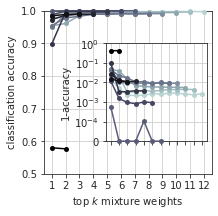

In [222]:
def get_topk_classifer_axis(ax,Krange,topkstore):
    pycolors=pl.cm.bone(np.linspace(0, 0.8, 11))

    for kit,K in enumerate(Krange[::-1]):
        ax.plot(range(1,K+1),np.mean(topkstore[:,:K,10-kit],axis=0),'.-',color=pycolors[10-kit],clip_on=False,zorder=4)
    ax.set_ylim(0.5,1)
    ax.set_ylabel('classification accuracy')
    ax.set_xlabel(r'top $k$ mixture weights')
    ax.set_xticks(range(1,Krange[-1]+1))

    axt = inset_axes(ax,width='60%',height='60%',loc=5)
    for kit,K in enumerate(params['Krange'][::-1]):
        dattmp=1-np.mean(topkstore[:,:K,10-kit],axis=0)
        dattmp[dattmp==0]=1e-5
        axt.plot(range(1,K+1),dattmp,'.-',color=pycolors[10-kit],clip_on=False,zorder=4)
    axt.set_yscale('log')
    axt.set_ylim(1e-5,1e0)
    # axt.set_ylim(0.95,1)
    axt.set_facecolor("white")
    axt.set_xticks(range(1,Krange[-1]+1))
    axt.set_xticklabels(['' for it in range(12)])
    axt.set_yticks([1e-5,1e-4,1e-3,1e-2,1e-1,1e0])
    axt.set_yticklabels([r"0",r"$10^{-4}$",r"$10^{-3}$",r"$10^{-2}$",r"$10^{-1}$",r"$10^{0}$"])
    axt.set_ylabel('1-accuracy')
    return ax,axt
    # fig.savefig(fig_dir+"accuracy_topktopics2.png", facecolor=fig.get_facecolor(),transparent=False,bbox_inches="tight",dpi=300)
fig,ax=pl.subplots(figsize=(3,3))
get_topk_classifer_axis(ax,Kranget,topkstoret)
fig.set_facecolor("white")

Check top 2 topics for K=7

Building corpus... 
Converting to Lower Case... 
Removing punctuation... 
Removing stopwords... 
Removing numbers... 
Stemming... 
Creating Output... 
Removing 907 of 2168 terms (907 of 25144 tokens) due to frequency 
Removing 10 Documents with No Words 
Your corpus now has 3219 documents, 1261 terms and 24237 tokens.
[6 4]
2613
[1] "Encourage la population au transport en commun ou à l’achat de voiture électrique. Beaucoup moins nocif pour l’environnement"

[0.682840432451272, 0.022815966787215907]
617
[1] "It is only a tax grab by government, and to appease the environmental lobby"

[0.019901744086255918, 0.4906170186302448]


<AxesSubplot:xlabel='$t_5$ ~Effective Incentive', ylabel='$t_7$ ~Malicious Injustice'>

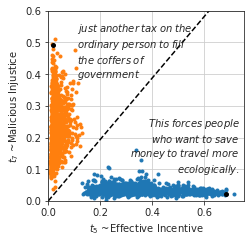

In [234]:
def get_2topic_classifier_axis(ax):
    sig_dict={1:'1',0:'0',0.5:'half'}#,0.2:'d2',0.4:'d4',0.6:'d6',.8:'d8'}
    sigma=0.5
    run_label='all_model_sigma'+sig_dict[sigma]
    meta_data_names=['restype',
                    'partisanship',
                 'partyvote',
                 'caruse',
                 'livingenv',
                 'agedec',
                 'sex',
                 'prov']
#     restypelist=['support','oppose','notsure']
#     restypelist=['all']
    restype='all'
    batch_name = restype + "_reponses_" + run_label
    params=np.load(models_dir+batch_name+'.npy',allow_pickle=True).item()
    resp_data=fdf.loc[:,['id','res','resclean']+meta_data_names].copy().reset_index(drop=True)
    pre_process_stm(resp_data)
    pcorp=dict(robjects.r.processed_corpus.items())
    seed=1
    nrows=3
    figsize=3
    sample_size=10
    scorestore=np.zeros((sample_size,len(params['Krange'])))#,len(sig_dict)))
    coefsstore=np.zeros((params['Krange'][-1],len(params['Krange'])))#,len(sig_dict)))
    topkstore=np.zeros((sample_size,params['Krange'][-1],len(params['Krange'])))
    kit=5
    K=7
    run_name=params['batch_name']+'_K_'+str(K)+'_seed_'+str(seed)
    robjects.r('load(file = "'+models_dir+run_name+'.rda")');
    fitobj=dict(robjects.r.fitobj.items())
    support_res=fitobj['theta'][pcorp['meta']['restype'].values=='support']
    oppose_res=fitobj['theta'][pcorp['meta']['restype'].values=='oppose']
    data=np.vstack((support_res,oppose_res))
    scaler = preprocessing.StandardScaler().fit(data)
    support_res = scaler.transform(support_res)
    oppose_res = scaler.transform(oppose_res)
    data=np.vstack((support_res,oppose_res))
    target_label = [1]*len(support_res)+ [0]*len(oppose_res)
    scores=[]
    coefs=np.zeros((sample_size,K))
    for sample in range(sample_size):
        X_train, X_test, y_train, y_test=train_test_split(data,target_label,test_size=0.33)
        clf=LogisticRegression(random_state=0,penalty='none').fit(X_train,y_train)
        scores.append(clf.score(X_test,y_test))
        coefs[sample,:]=clf.coef_[0]
    scorestore[:,kit]=scores
    coefsstore[:K,kit]=np.mean(coefs,axis=0)
    
    support_res=fitobj['theta'][pcorp['meta']['restype'].values=='support']
    oppose_res=fitobj['theta'][pcorp['meta']['restype'].values=='oppose']
    data=np.vstack((support_res,oppose_res))
    sorted_inds=np.argsort(np.fabs(clf.coef_[0]*np.mean(data,axis=0)))[::-1]
    
    topk=2
    topklist=sorted_inds[:topk]
    print(topklist)
    support_res=fitobj['theta'][pcorp['meta']['restype'].values=='support'][:,topklist]
    oppose_res=fitobj['theta'][pcorp['meta']['restype'].values=='oppose'][:,topklist]
    ax.scatter(support_res[:,0],support_res[:,1],marker='.')
    ax.scatter(oppose_res[:,0],oppose_res[:,1],marker='.')
    xtop=topklist[0]
    ytop=topklist[1]
    ax.plot(clf.coef_[0][xtop]*np.linspace(0,0.75,10),-clf.coef_[0][ytop]*np.linspace(0,0.75,10),'k--')
    ax.set_xlabel(r'$t_5$ ~Effective Incentive')
    ax.set_ylabel(r'$t_7$ ~Malicious Injustice')
    ax.set_xlim(0,0.75)
    ax.set_ylim(0,0.6)
    
#     res_id=2739
#     topresps=[np.argmax(fitobj['theta'][:,topklist[ind]]) for ind in range(2)]
#     print(topresps)
#     print([pcorp['meta']['res'] for res_id in topresps])
#     print([np.max(fitobj['theta'][:,topklist[ind] for ind in range(2)]
#     ax.plot([np.exp(dict(fitobj['beta'].items())['logbeta'][0][topklist[0],res_id])],
#             [np.exp(dict(fitobj['beta'].items())['logbeta'][0][topklist[1],res_id])],'k.')

    res_id=np.argsort(fitobj['theta'][:,xtop])[-3]
    print(res_id)
    print(robjects.r('processed_corpus$meta$res['+str(res_id+1)+']'))
    coords=[fitobj['theta'][res_id,ttop] for ttop in [xtop,ytop]]
    print(coords)
    ax.plot([coords[0]],[coords[1]],'k.')
    
    res_id=np.argsort(fitobj['theta'][:,ytop])[-3]
    print(res_id)
    print(robjects.r('processed_corpus$meta$res['+str(res_id+1)+']'))
    coords=[fitobj['theta'][res_id,ttop] for ttop in [xtop,ytop]]
    print(coords)
    ax.plot([coords[0]],[coords[1]],'k.')
#     res_id=2452
#     res_id=np.argsort(robjects.r('fitobj$theta[,'+str(ytop+1)+']'))[-1]+1
#     print(res_id)
#     print(robjects.r('processed_corpus$meta$res['+str(res_id+1)+']'))
#     coords=[robjects.r('fitobj$theta['+str(res_id)+','+str(ttop+1)+']') for ttop in [xtop,ytop]]
#     print(coords)
#     ax.plot([coords[0]],[coords[1]],'kx')
    ax.text(0.98,0.15,r"$This\;forces\; people$"+'\n'+r"$who\;want\; to\; save$"+'\n'+r"$money\;to\; travel\; more$"+'\n'+"$ecologically.$",ha='right',transform=ax.transAxes)
#     ax.text(0.5,0.3,r"$Because\;it's$"+'\n'+r'$the\; sensible \;thing$'+"\n"+r"$to\; do\;...$",transform=ax.transAxes)
    ax.text(0.15,0.65,'$just\; another\; tax\; on\;the $'+'\n'+r'$ordinary\; person\; to\; fill$'+'\n'+r"$the\;coffers\;of$"+'\n'+"$government$",transform=ax.transAxes)
#     ax.text(0.07,0.7,r"$Because \;it\; doesn't\; deal\; with$"+'\n'+r"$the\; massive\; pollution$"+'\n'+r"$problems\; in \;other$"+'\n'+r"$countries.$",transform=ax.transAxes)
#     ax.plot([fitobj['theta'][res_id,topklist[0]]],[fitobj['theta'][res_id,topklist[1]]],'kx')
#     ax.plot([np.exp((fitobj['beta'].items())['logbeta'][0][topklist[0],res_id])],
#             [np.exp((fitobj['beta'].items())['logbeta'][0][topklist[1],res_id])],'k.')
    return ax
fig,ax=pl.subplots(figsize=(3.5,3.5))
get_2topic_classifier_axis(ax)

In [120]:
res_id=2739
# res_id=2452
robjects.r('processed_corpus$meta$res['+str(res_id)+']')

"""Because it's the sensible thing to do--providing..."


In [23]:
shownwords=10
pd.options.display.max_colwidth=100
test1=robjects.r('labelTopics(fitobj,n='+str(shownwords)+')')
topicwords=pd.Series(np.asarray(test1.rx[1][0]).reshape((shownwords,K)).T.tolist(),index=range(1,K+1))
topicwords.index.name='topicid'

In [29]:
test1

prob,[RTYPES.STRSXP]
frex,[RTYPES.STRSXP]
lift,[RTYPES.STRSXP]
score,[RTYPES.STRSXP]
topicnums,[RTYPES.INTSXP]


In [24]:
topicwords

topicid
1                [pay, alreadi, cost, enough, know, peopl, live, much, work, afford]
2                    [money, mak, think, way, get, make, consum, altern, anyth, big]
3              [fuel, use, reduc, carbon, chang, emiss, fossil, peopl, climat, help]
4       [canada, carbon, countri, effect, world, problem, pollut, believ, one, heat]
5                 [tax, govern, anoth, grab, noth, put, price, car, canadian, still]
6       [need, environ, like, support, thing, someth, option, energi, wast, resourc]
7    [tax, peopl, environ, energi, less, pollut, encourag, altern, compani, protect]
dtype: object

In [160]:
showndocs=10
tmp=robjects.r('findThoughts(fitobj,texts='+\
       'processed_corpus$meta$res'+\
       ',n='+str(showndocs)+')')
top_responses={}
for topic_id,indvec in enumerate(dict(tmp.items())['index']):
    print(indvec)
    top_responses[str(topic_id+1)]=[robjects.r('processed_corpus$meta$res['+str(ind)+']')[0] for ind in indvec]
top_responses

[ 234  930  446 2972 1702 2162 2461 1397 1103 2933]
[2167 2134  354 1928  635 2525 1480  551 2957 1631]
[ 390 1431   12 2044 1924  303  584 2353 2135  550]
[ 623 2452 1020 1296 2813 1650 1800  586 2774 1684]
[1316 2430  618 2392 2706 1003 3146 2938 2516  502]
[ 955  313 2739 2259 1152   27 1008 3033  150 2090]
[1612 2784 2614 2757 1238 1400  469 1838  217 1005]


{'1': ['Je ne suis pas assez au courant pour me prononcer et je ne suis pas certaine que cela sera bien géré',
  'I don’ Know enough ..I don’t watch news or read paper.Only sad news now',
  "Je n'ai pas assez d'informations pour me prononcer.",
  "Je ne me suis pas informé sur le sujet alors je n'en connais pas spécialement les enjeux principaux.",
  'Not familiar Dont know enough about this',
  "I don't pay too much attention. Just pay my bills.",
  "don't have much info on it to  have an opinion",
  "Je n'ai pas beaucoup entendu parler, donc mon opinion est neutre pour l'instant. Je devrais m'informer un peu plus Sur La question.",
  'Il y a des "extrémistes" des deux côtés du spectre, qui n\'hésitent pas à mentir pour avoir l\'opinion publique de leur côté.',
  "Plusieurs personnes doivent payer l'essence pour ce rendre a leur travaille de manière obligatoire pour nourrir leur famille et ils ont pas les moyens de payer une taxe pour l'essence en plus de tous"],
 '2': ["It won't chan

In [ ]:
nwords=7
K=39
test1=robjects.r('labelTopics(fit,n='+str(nwords)+')')
topicwords=pd.Series(np.asarray(test1.rx[1][0]).reshape((nwords,K)).T.tolist(),index=range(1,K+1))
topicwords.index.name='topicid'
print(topicwords.values)
robjects.r('plot(fit)')

double assumed number of topics

In [ ]:
yield_seed = lambda x: robjects.NULL if x==None else x
robjects.globalenv["fit"] = robjects.r.stm(
    robjects.r("processed_corpus$documents"), 
    robjects.r("processed_corpus$vocab"), 
    K=2*K, data=robjects.r("processed_corpus$meta"),
    init_type=init_type, seed=yield_seed(seed),max_em_its=max_em_its)

In [ ]:
nwords=7
test1=robjects.r('labelTopics(fit,n='+str(nwords)+')')
topicwords=pd.Series(np.asarray(test1.rx[1][0]).reshape((nwords,2*K)).T.tolist(),index=range(1,2*K+1))
topicwords.index.name='topicid'
print(topicwords.values)
robjects.r('plot(fit)')

In [ ]:
data=robjects.r('processed_corpus_temp$documents')
test1=pd.DataFrame.from_records([doc for doc in data.items()],index=[0]).drop(0,axis=1)
stmclean_corpus.rename(columns={1: question_id_name+'clean_stems_keepwordvec'},inplace=True)
test1.index.name= None
test1

In [ ]:
K=5#7#12
init_type="Spectral"
seed=None
max_em_its=500
emtol=1e-5
verbose=False#True
reportevery=5
LDAbeta=True
interactions=True
ngroups=1
gamma_prior="Pooled"
sigma_prior=0
kappa_prior="L1"
# model_parameters={
#     'K': 10,  # number of topics
#     'LDAbeta': LDAbeta,
#     'gamma_prior':,
#     'sigma_prior':,
#     'kappa_prior':
# }
# inference_options = {
#     'init_type': init_type,
#     'seed':,
#     'max_em_its':,
#     'emtol':,
#     'verbose':,
#     'ngroups':1,
# }

2D projection

In [37]:
from matplotlib.colors import LogNorm

In [206]:
def get_PCA_classifier(fig,gs):
    sigma=0.5
    run_label='all_model_sigma'+sig_dict[sigma]
    meta_data_names=['restype',
    #                  'warmingcause',
                    'partisanship',
                 'partyvote',
                 'caruse',
                 'livingenv',
                 'agedec',
                 'sex',
                 'prov']
    restypelist=['support','oppose','notsure']
    restypelist=['all']
    restype='all'
    batch_name = restype + "_reponses_" + run_label
    params=np.load(models_dir+batch_name+'.npy',allow_pickle=True).item()
    resp_data=fdf.loc[:,['id','res','resclean']+meta_data_names].copy().reset_index(drop=True)

    pre_process_stm(resp_data)
    pcorp=dict(robjects.r.processed_corpus.items())

    seed=1
    nrows=1
    figsize=1
    sample_size=10
#     figev,axev=pl.subplots(nrows,len(params['Krange'])-1,figsize=(figsize*(len(params['Krange'])-1),nrows*figsize))

    for kit,K in enumerate(params['Krange'][1:]):
        axev=fig.add_subplot(gs[0,kit])
        if kit==0:
            storeax=axev
        run_name=params['batch_name']+'_K_'+str(K)+'_seed_'+str(seed)
        robjects.r('load(file = "'+models_dir+run_name+'.rda")');

        fitobj=dict(robjects.r.fitobj.items())

        covariance_matrix = np.cov(fitobj['theta'].T)
        correlation_matrix = np.corrcoef(fitobj['theta'].T)
        cov_eigen_values, cov_eigen_vectors=linalg.eigh(covariance_matrix)
        corr_eigen_values, corr_eigen_vectors=linalg.eigh(correlation_matrix)
        for cit,(cmapit,restype2) in enumerate(zip(['Blues','Oranges'],['support','oppose'])):

            res_data=fitobj['theta'][pcorp['meta']['restype'].values==restype2]     
            proj_res_data = res_data.dot(cov_eigen_vectors[:,-2:])
            p=axev.hist2d(proj_res_data[:,0],proj_res_data[:,1],bins=50,cmap=cmapit,norm=LogNorm())#vmin=1,vmax=3319))
            if cmapit=='Oranges':
                newxlims=axev.get_xlim()
                newylims=axev.get_ylim()
                axev.set_xlim(min([newxlims[0],oldxlims[0]]),max([newxlims[1],oldxlims[1]]))
                axev.set_ylim(min([newylims[0],oldylims[0]]),max([newylims[1],oldylims[1]]))
            oldxlims=axev.get_xlim()
            oldylims=axev.get_ylim()
        axev.grid(False)
        axev.get_xaxis().set_visible(False)
        axev.get_yaxis().set_visible(False)
        axev.set_title(r'$K='+str(K)+'$')
        cir=pl.Circle(xy=(1.0,1.2),transform=axev.transAxes,radius=0.05,color=pycolors[kit],clip_on=False)
        axev.add_patch(cir)
    return storeax

All together

In [207]:
import matplotlib.gridspec as gridspec

Building corpus... 
Converting to Lower Case... 
Removing punctuation... 
Removing stopwords... 
Removing numbers... 
Stemming... 
Creating Output... 
Removing 907 of 2168 terms (907 of 25144 tokens) due to frequency 
Removing 10 Documents with No Words 
Your corpus now has 3219 documents, 1261 terms and 24237 tokens.


/tmp/ipykernel_37908/1886508970.py:46: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  p=axev.hist2d(proj_res_data[:,0],proj_res_data[:,1],bins=50,cmap=cmapit,norm=LogNorm())#vmin=1,vmax=3319))


Building corpus... 
Converting to Lower Case... 
Removing punctuation... 
Removing stopwords... 
Removing numbers... 
Stemming... 
Creating Output... 
Removing 907 of 2168 terms (907 of 25144 tokens) due to frequency 
Removing 10 Documents with No Words 
Your corpus now has 3219 documents, 1261 terms and 24237 tokens.
[6 4]
2613
[1] "Encourage la population au transport en commun ou à l’achat de voiture électrique. Beaucoup moins nocif pour l’environnement"

[0.682840432451272, 0.022815966787215907]
617
[1] "It is only a tax grab by government, and to appease the environmental lobby"

[0.019901744086255918, 0.4906170186302448]


Text(0.0, 0.05, '=')

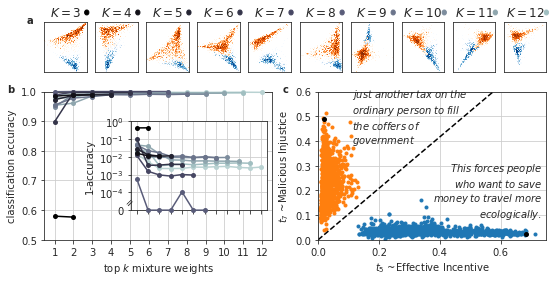

In [237]:
fig=pl.figure(figsize=(9,4))
gs=fig.add_gridspec(nrows=2,ncols=1,height_ratios=[1,3])

gstop=gridspec.GridSpecFromSubplotSpec(nrows=1,ncols=10,subplot_spec=gs[0])
axa=get_PCA_classifier(fig,gstop)

gsbottom=gridspec.GridSpecFromSubplotSpec(nrows=1,ncols=2,subplot_spec=gs[1])#,hspace=30)
axbleft=fig.add_subplot(gsbottom[0])
axb,axt=get_topk_classifer_axis(axbleft,Kranget,topkstoret)

axbright=fig.add_subplot(gsbottom[1])
axc=get_2topic_classifier_axis(axbright)

axa.text(-0.25,1.15,'a',transform=axa.transAxes,fontsize=10,fontweight='bold',va='top',ha='right')
axb.text(-0.13,1.05,'b',transform=axb.transAxes,fontsize=10,fontweight='bold',va='top',ha='right')
axc.text(-0.13,1.05,'c',transform=axc.transAxes,fontsize=10,fontweight='bold',va='top',ha='right')
axt.text(0.0,0.05,'=',rotation=45,ha='center',transform=axt.transAxes)

In [238]:
fig.savefig("Figure_5.pdf",transparent=False,bbox_inches="tight",dpi=300)
